In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
from astropy.io import fits
base_path = '/Users/ruby/EoR'
sys.path.append('{}/pyuvdata'.format(base_path))
import pyuvdata
from pyuvdata import UVData

In [37]:
weights_xx_path = '/Users/ruby/EoR/1061316296_UV_weights_XX.fits'
weights_yy_path = '/Users/ruby/EoR/1061316296_UV_weights_YY.fits'

In [41]:
weights = []
for filename in [weights_xx_path, weights_yy_path]:
    contents = fits.open(filename)
    use_hdu = 0
    weights.append(np.array(contents[use_hdu].data))
header = contents[use_hdu].header
u_axis = np.array([
    header['CRVAL1'] +
    header['CD1_1']*(pix_ind-header['CRPIX1'])
    for pix_ind in range(header['NAXIS1'])
    ])
v_axis = np.array([
    header['CRVAL2'] +
    header['CD2_2']*(pix_ind-header['CRPIX2'])
    for pix_ind in range(header['NAXIS2'])
    ])

weights = (weights[0]+weights[1])/2.

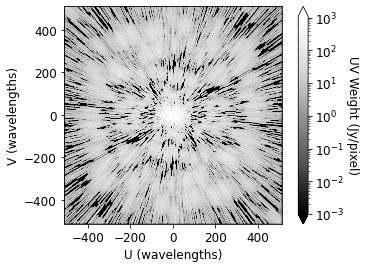

In [211]:
plt.figure(figsize=(6, 4))
colorbar_range = [.001, 0.5*np.max(weights)]
weights_use = np.copy(weights)
weights_use[np.where(weights < colorbar_range[0])] = colorbar_range[0]
plt.imshow(
    weights_use, origin='lower', interpolation='none',
    cmap='Greys_r',
    extent=[u_axis[0], u_axis[-1], v_axis[0], v_axis[-1]],
    aspect='equal', norm=LogNorm(vmin=colorbar_range[0], vmax=colorbar_range[1])
)
plt.xlim([u_axis[0], u_axis[-1]])
plt.ylim([v_axis[0], v_axis[-1]])
plt.xlabel('U (wavelengths)')
plt.ylabel('V (wavelengths)')
cbar = plt.colorbar(extend='both')
cbar.ax.set_ylabel('UV Weight (Jy/pixel)', rotation=270, labelpad=15)
plt.savefig('/Users/ruby/Downloads/uv_weights.png', format='png', dpi=600)
plt.show()

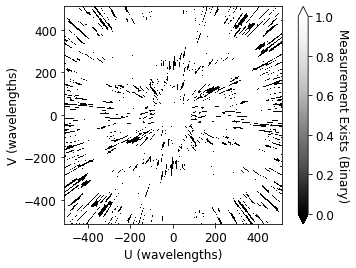

In [67]:
weights_zeros = np.copy(weights)
weights_zeros[np.where(weights == 0.)] = 0.
weights_zeros[np.where(weights != 0.)] = 1

plt.figure(figsize=(6, 4))
plt.imshow(
    weights_zeros, origin='lower', interpolation='none',
    cmap='Greys_r',
    extent=[u_axis[0], u_axis[-1], v_axis[0], v_axis[-1]],
    aspect='equal', vmin=0, vmax=1
)
plt.xlim([u_axis[0], u_axis[-1]])
plt.ylim([v_axis[0], v_axis[-1]])
plt.xlabel('U (wavelengths)')
plt.ylabel('V (wavelengths)')
cbar = plt.colorbar(extend='both')
cbar.ax.set_ylabel('Measurement Exists (Binary)', rotation=270, labelpad=15)
plt.show()

In [198]:
u_axis_array, v_axis_array = np.meshgrid(u_axis, v_axis)
distance = np.sqrt(u_axis_array**2. + v_axis_array**2.)
nbins = 1000
count_zeros_bin_edges = np.arange(0, np.max(u_axis), np.max(u_axis_array)/nbins)
count_zeros = np.zeros(len(count_zeros_bin_edges)-1)
for bin_ind, bin_start in enumerate(count_zeros_bin_edges[:-1]):
    bin_end = count_zeros_bin_edges[bin_ind+1]
    u_inds, v_inds = np.where((distance >= bin_start) & (distance < bin_end))
    if len(u_inds) > 0:
        count_zeros[bin_ind] = np.float(np.sum(weights_zeros[u_inds, v_inds]))/np.float(len(u_inds))
count_zeros_bin_centers = np.array([
    (count_zeros_bin_edges[ind]+count_zeros_bin_edges[ind+1])/2. for ind in range(len(count_zeros_bin_edges)-1)
])

[0.36239223 1.08717668 1.81196113 2.53674558 3.26153003 3.98631448
 4.71109893 5.43588338 6.16066783 6.88545228]


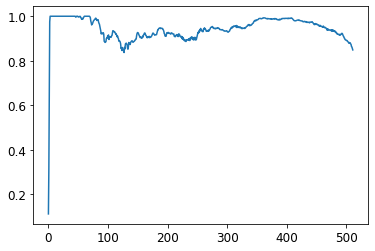

In [197]:
plt.plot(count_zeros_bin_centers, count_zeros, '-')
print(count_zeros_bin_centers[0:10])
plt.show()

In [2]:
uv = UVData()
uv.read_uvfits('{}/1061316296.uvfits'.format(base_path), read_data=False)
baseline_lengths = np.sqrt(np.sum(np.abs(uv.uvw_array)**2., axis=1))
baseline_lengths = np.array(list(set(baseline_lengths)))

Required Antenna frame keyword not set, but this appears to be a Cotter file, setting to ITRF.


In [15]:
baseline_lengths_all = np.zeros((len(baseline_lengths), 384))
for freq_ind in range(384):
    baseline_lengths_all[:, freq_ind] = (
        baseline_lengths*(uv.freq_array[0, freq_ind])/(3.*10**8)
    )
baseline_lengths_all = baseline_lengths_all.flatten()
baseline_lengths_all = baseline_lengths_all[
    np.where(baseline_lengths_all != 0.)
]
baseline_lengths_log = np.log10(baseline_lengths_all)
baseline_hist, bin_edges_log = np.histogram(baseline_lengths_log, bins=100)
bin_edges = 10**bin_edges_log

plot_xvals = [bin_edges[0]]
plot_yvals = [0.]
for bin_ind in range(len(bin_edges)-1):
    plot_xvals.extend([bin_edges[bin_ind], bin_edges[bin_ind+1]])
    plot_yvals.extend([baseline_hist[bin_ind], baseline_hist[bin_ind]])
plot_xvals.append(bin_edges[-1])
plot_yvals.append(0.)
plot_xvals = np.array(plot_xvals)
plot_yvals = np.array(plot_yvals)

In [190]:
def wl_to_angles(wl):
    wl[np.where(wl < 1)] = 1
    return_val = 2.*np.arcsin(1/wl)*180/np.pi
    return return_val
def angles_to_wl(angle):
    return_val = np.zeros_like(angle)
    where_nonzero = np.where(angle < 180.)
    return_val[where_nonzero] = 0.5/np.sin(angle[where_nonzero]*np.pi/180)
    return return_val

divide by zero encountered in true_divide


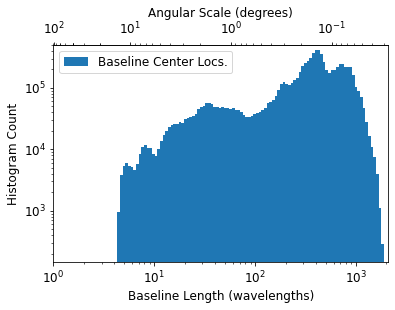

In [98]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(6, 4))
plt.fill_between(
    plot_xvals, 0, plot_yvals, alpha=1, label='Baseline Center Locs.'
)
plt.xscale('log')
plt.yscale('log')
ylims = np.array([
    0.5*np.min(plot_yvals[np.where(plot_yvals > 0)]),
    1.2*np.max(plot_yvals)
])
plt.ylim(ylims)
xlim_wavelengths = np.array([1, 1.1*np.max(plot_xvals)])
ax.set_xlim(xlim_wavelengths)
ax.set_xscale('log')
ax2 = ax.secondary_xaxis('top', functions=(wl_to_angles, angles_to_wl))
ax2.set_xlabel('Angular Scale (degrees)')
ax.set_xlabel('Baseline Length (wavelengths)')
ax.set_ylabel('Histogram Count')
ax.legend(loc=2)
plt.show()

<Figure size 432x288 with 0 Axes>

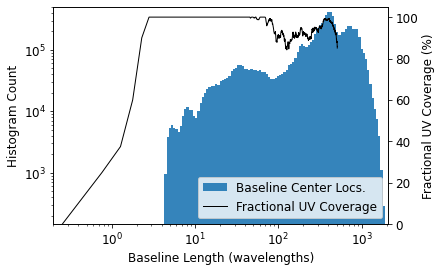

In [212]:
plt.clf()
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(6, 4))
plt.fill_between(
    plot_xvals, 0, plot_yvals, alpha=.9, label='Baseline Center Locs.'
)
plt.xscale('log')
plt.yscale('log')
ylims = np.array([
    0.5*np.min(plot_yvals[np.where(plot_yvals > 0)]),
    1.2*np.max(plot_yvals)
])
plt.ylim(ylims)
xlim_wavelengths = np.array([.2, 1.1*np.max(plot_xvals)])
ax.set_xlim(xlim_wavelengths)
ax.set_xscale('log')
#ax2 = ax.secondary_xaxis('top', functions=(wl_to_angles, angles_to_wl))
#ax2.set_xlabel('Angular Scale (degrees)')
ax.set_xlabel('Baseline Length (wavelengths)')
ax.set_ylabel('Histogram Count')

ax3 = ax.twinx()
ax3.set_ylabel('Fractional UV Coverage (%)')
ax3.plot(count_zeros_bin_centers, count_zeros*100., '-', color='black', label='Fractional UV Coverage', linewidth=1)
ax3.set_xlim(xlim_wavelengths)
ax3.set_xscale('log')
ax3.set_ylim(0, 105)

legend_styles1, legend_labels1 = ax.get_legend_handles_labels()
legend_styles2, legend_labels2 = ax3.get_legend_handles_labels()
plt.legend(legend_styles1+legend_styles2, legend_labels1+legend_labels2, loc=4)

plt.savefig('/Users/ruby/Downloads/baseline_coverage.png', format='png', dpi=600)
plt.show()